# **Merge dataframes**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path
from collections import defaultdict

from lynx_id.utils.preprocess.utils import flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

pd.set_option('display.max_colwidth', None)

## **Merge**

In [3]:
DATASET = Path("/lustre/fsn1/projects/rech/ads/commun/datasets/extracted/")

In [4]:
# Load them locally
france_dataset = pd.read_csv(DATASET / "france" / "lynx_dataset_france.csv")
croatia_dataset = pd.read_csv(DATASET / "croatia" / "lynx_dataset_croatia.csv")
slovenia_dataset = pd.read_csv(DATASET / "slovenia" / "lynx_dataset_slovenia.csv")
germany_dataset = pd.read_csv(DATASET / "germany" / "lynx_dataset_germany.csv")
norway_dataset = pd.read_csv(DATASET / "norway" / "lynx_dataset_norway.csv")
swiss_dataset = pd.read_csv(DATASET / "swiss" / "lynx_dataset_swiss.csv")
spain_dataset = pd.read_csv(DATASET / "spain" / "lynx_dataset_spain.csv")

print(f"{france_dataset.shape=}")
print(f"{croatia_dataset.shape=}")
print(f"{slovenia_dataset.shape=}")
print(f"{germany_dataset.shape=}")
print(f"{norway_dataset.shape=}")
print(f"{swiss_dataset.shape=}")
print(f"{spain_dataset.shape=}")

france_dataset.shape=(3081, 15)
croatia_dataset.shape=(1663, 21)
slovenia_dataset.shape=(1945, 18)
germany_dataset.shape=(5115, 15)
norway_dataset.shape=(9682, 15)
swiss_dataset.shape=(22404, 15)
spain_dataset.shape=(1536, 15)


In [5]:
df_full = pd.concat([france_dataset, croatia_dataset, slovenia_dataset, germany_dataset, swiss_dataset, spain_dataset], ignore_index=True)
df_full[['filepath', 'lynx_id', 'country']]

,filepath,lynx_id,country
0,/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-04-27_NA_5.JPG,van-gogh,France
1,/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-05-05_NA_1.JPG,van-gogh,France
2,/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-17_NA_3.JPG,van-gogh,France
3,/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-16_NA_6.JPG,van-gogh,France
4,/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-05_NA_7.JPG,van-gogh,France
...,...,...,...
35739,/gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Malabar (8).jpg,malabar,spain
35740,/gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Arce (26).jpg,arce,spain
35741,/gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Piqueros (7).JPG,piqueros,spain
35742,/gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/RELICTO_I1.jpg,relicto,spain


In [6]:
all(df_full['filepath'].apply(os.path.exists))

True

In [7]:
all(df_full['filepath_no_bg'].apply(os.path.exists))

True

Note: the Norwegian dataset has not yet been added.

## **Number of images per country**

<Axes: xlabel='country'>

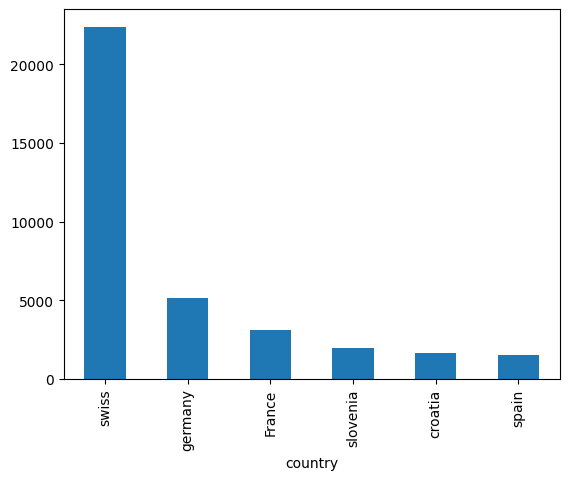

In [8]:
df_full['country'].value_counts().plot(kind='bar')

## **Are the same lynx_ids used in different countries?**

In [9]:
df_full.nunique()['lynx_id']

1771

In [10]:
france_dataset.nunique()['lynx_id'] + croatia_dataset.nunique()['lynx_id'] + slovenia_dataset.nunique()['lynx_id'] + germany_dataset.nunique()['lynx_id'] + swiss_dataset.nunique()['lynx_id'] + spain_dataset.nunique()['lynx_id']

1976

Some lynx_ids are redundant between countries. Let's take a look at which ones and in which countries they apply.

In [11]:
lynx_country_counts = df_full.groupby(['lynx_id', 'country']).size().reset_index(name='count')
lynx_country_counts

,lynx_id,country,count
0,01,swiss,3
1,02,swiss,13
2,03,swiss,2
3,04,swiss,13
4,05,swiss,11
...,...,...,...
1971,zita,croatia,10
1972,zita,swiss,2
1973,zois,slovenia,4
1974,zoro,swiss,12


In [12]:
lynx_id_country_groups = lynx_country_counts.groupby('lynx_id').agg({'country': lambda x: list(x), 'count': lambda x: list(x)}).reset_index()
lynx_id_country_groups

,lynx_id,country,count
0,01,[swiss],[3]
1,02,[swiss],[13]
2,03,[swiss],[2]
3,04,[swiss],[13]
4,05,[swiss],[11]
...,...,...,...
1766,zikh,[swiss],[6]
1767,zita,"[croatia, swiss]","[10, 2]"
1768,zois,[slovenia],[4]
1769,zoro,[swiss],[12]


In [13]:
shared_lynx_ids = lynx_id_country_groups[lynx_id_country_groups['country'].apply(len) > 1]
shared_lynx_ids

,lynx_id,country,count
9,10,"[germany, swiss]","[2, 11]"
10,100,"[France, swiss]","[5, 7]"
27,1015,"[France, swiss]","[3, 3]"
29,1017,"[France, swiss]","[2, 3]"
30,1018,"[France, swiss]","[2, 2]"
...,...,...,...
1450,mata,"[France, swiss]","[3, 78]"
1483,naia,"[spain, swiss]","[15, 46]"
1527,odin,"[croatia, swiss]","[4, 1]"
1734,toni,"[croatia, swiss]","[35, 1]"


In [14]:
for index, row in shared_lynx_ids.iterrows():
    countries_counts = ', '.join([f"{country}: {count}" for country, count in zip(row['country'], row['count'])])
    if 'croatia' in row['country'] and 'germany' in row['country']:
        print(f"{row['lynx_id']}\t | {countries_counts}")

As the notation is country-specific, we are adding a suffix to the lynx_id corresponding to the country.

In [15]:
country_mapping = {
    "France": "FR",
    "croatia": "HR",
    "slovenia": "SI",
    "germany": "DE",
    "swiss": "CH",
    "spain": "ES"
}

In [16]:
df_full['lynx_id'] = df_full.apply(lambda row: f"{row['lynx_id']}_{country_mapping.get(row['country'])}", axis=1)

In [17]:
df_full.nunique()['lynx_id']

1976

In [18]:
# print(set(df_full['lynx_id'].tolist()))

## **View some images**

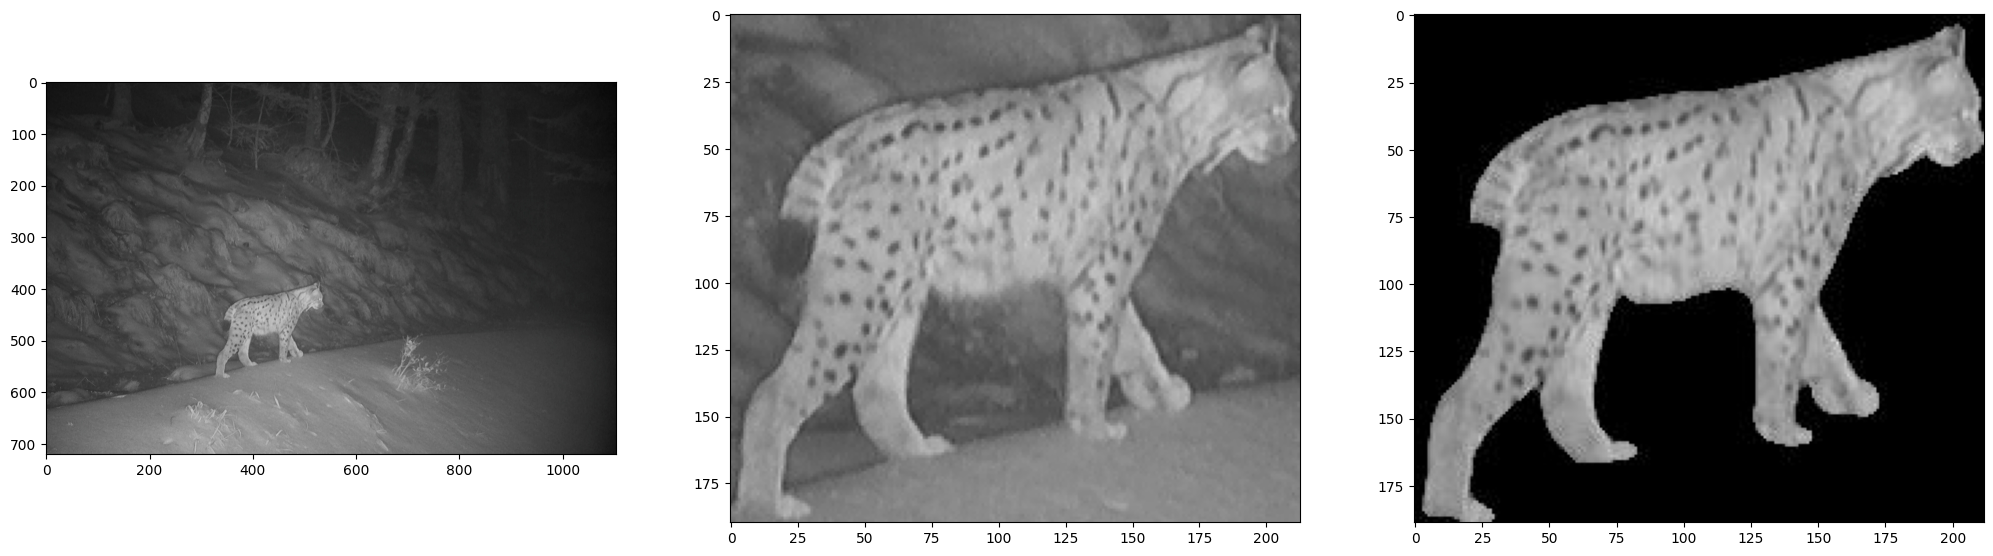

In [19]:
idx=10

fig, axes = plt.subplots(1, 3, figsize=(25,10))

axes[0].imshow(Image.open(df_full.iloc[idx]['filepath']))
axes[1].imshow(crop_bbox(df_full.iloc[idx]))
axes[2].imshow(Image.open(df_full.iloc[idx]['filepath_no_bg']))

## **Save to csv**

In [20]:
df_full.to_csv(DATASET / f"lynx_dataset_full_v2.csv", index=False)

## **OPTIONAL : Updating image path prefixes**

## **Fix some `lynx-id` from France**

Some lynx_ids seem to be duplicates. We keep only for a “same” lynx_id, i.e. one whose name is included in another, the **one with the most images**, as some images are also redundant between these lynx_ids.

In [18]:
df_full = pd.read_csv(Path("/lustre/fsn1/projects/rech/ads/commun/datasets/extracted/lynx_dataset_full_v2.csv"))

/tmp/xpython_1405680/2173998023.py:1: DtypeWarning: Columns (2,3,4,5,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(Path("/lustre/fsn1/projects/rech/ads/commun/datasets/extracted/lynx_dataset_full_v2.csv"))


In [19]:
all_unique_lynx_id = [element.rstrip('_FR') for element in sorted(set(df_full[df_full['country'] == 'France'].lynx_id.tolist()))]
print(all_unique_lynx_id)

['100', '1015', '1017', '1018', '1033=l286', '1044=l261', '1068', '1070', '1079', '1098', '1107', '1115', '1121', '1128', '1131', '1184', '1185', '1208', '1217', '1219', '1224', '1225', '1232', '1246', '124', '1254', '1261', '1265', '1269', '1275', '1276=1278', '1277', '1286', '1292', '1294', '1296=1298', '1300', '1302', '1306', '1308', '1313', '1317', '1320', '1321', '1324', '1342', '1344', '1350=b2011-57', '1350=b2011', '1353=l306', '1370', '1376', '1388', '1397', '1404', '1408', '1413', '1417=oslo', '1436', '1448', '1461', '1479', '1480', '1499', '1502', '1504', '1509', '1512', '1528=b811', '1529', '1537', '1545', '1546=1580=b830', '1548', '1554', '1557', '1561', '1564', '1567', '1569', '1575', '1632', '163', '1704', '1717', '1720', '1722', '1725', '1735', '1756', '1759', '1764', '1765', '1771', '1772', '1780', '1781', '1813', '1864', '1914', '1920', '1921', '1939', '1942', '1947', '1975', '1976', '2001-67-fifo', '2071', '2081', '2101', '2109', '2114', '2125', '2132', '2166', '2208'

In [20]:
len(all_unique_lynx_id)

269

In [25]:
grouped_result = defaultdict(list)

# Loop to check each lynx_id
for lynx_id in all_unique_lynx_id:
    for other_lynx_id in all_unique_lynx_id:
        if other_lynx_id != lynx_id:
            # Check if the other lynx_id contains an '='
            if '=' in other_lynx_id:
                # Split the other lynx_id by the '=' character
                other_lynx_id_parts = other_lynx_id.split('=')
                other_lynx_id_parts = [item[1:] if item[0] in ['b', 'l', 'r'] else item for item in other_lynx_id_parts]
                # Check if the string matches exactly one of the parts
                if lynx_id in other_lynx_id_parts:
                    grouped_result[lynx_id + "_FR"].append(other_lynx_id + "_FR")

# Convert the results into tuples, each key becoming a tuple with its associated values
problematics_lynx_ids = [(key, *values) for key, values in grouped_result.items()]
problematics_lynx_ids.append(('fifo_FR', '2001-67-fifo_FR'))  # add another lynx_id which can't be captured with the previous algorithm
problematics_lynx_ids.append(('1350=b2011-57_FR', '1350=b2011_FR'))

print(problematics_lynx_ids)

[('1376_FR', 'f25-067=1376_FR'), ('1725_FR', 'f01-062=1725=1897_FR'), ('2125_FR', 'f73-006=2125_FR'), ('704_FR', 'f25-062=1050=1102=b704_FR'), ('arcos_FR', 'arcos=629_FR'), ('oslo_FR', '1417=oslo_FR', 'oslo=1417_FR'), ('fifo_FR', '2001-67-fifo_FR'), ('1350=b2011-57_FR', '1350=b2011_FR')]


In [26]:
# A tuple list where each element is a tuple containing a lynx_id with the number of times it appears in the dataset
new_tuples_list = []

for item in problematics_lynx_ids:
    transformed_tuple = []
    
    for element in item:        
        count_sum = df_full[df_full['lynx_id'] == element].shape[0]
        transformed_tuple.append((element, count_sum))
    
    new_tuples_list.append(tuple(transformed_tuple))

print(new_tuples_list)

[(('1376_FR', 24), ('f25-067=1376_FR', 55)), (('1725_FR', 4), ('f01-062=1725=1897_FR', 18)), (('2125_FR', 19), ('f73-006=2125_FR', 21)), (('704_FR', 14), ('f25-062=1050=1102=b704_FR', 9)), (('arcos_FR', 7), ('arcos=629_FR', 36)), (('oslo_FR', 12), ('1417=oslo_FR', 18), ('oslo=1417_FR', 35)), (('fifo_FR', 2), ('2001-67-fifo_FR', 25)), (('1350=b2011-57_FR', 36), ('1350=b2011_FR', 13))]


In [27]:
# For each tuple in the previous list, i.e. for each problematic lynx_id, we return the lynx_id(s) appearing least in the dataset to delete these images
def get_min_elements(tuples):
    # Sort tuples by associated value (the second element of each tuple)
    sorted_tuples = sorted(tuples, key=lambda x: x[1])
    
    # If it's a couple (two lynx_ids), return the one with the smaller value
    if len(sorted_tuples) == 2:
        return [sorted_tuples[0][0]]
        
    # If it's a triplet (three lynx_ids), return the two smallest
    elif len(sorted_tuples) == 3:
        return [sorted_tuples[0][0], sorted_tuples[1][0]]

# Loop through the list and apply the function
lynx_id_to_remove = []
for item in new_tuples_list:
    lynx_id_to_remove.extend(get_min_elements(item))  # Add results to final list

print(lynx_id_to_remove)

['1376_FR', '1725_FR', '2125_FR', 'f25-062=1050=1102=b704_FR', 'arcos_FR', 'oslo_FR', '1417=oslo_FR', 'fifo_FR', '1350=b2011_FR']


In [28]:
df_full.shape[0]

35744

In [29]:
df_filtered = df_full[~df_full['lynx_id'].isin(lynx_id_to_remove)]
df_filtered.shape[0]

35636

In [30]:
all_unique_lynx_id = [element.rstrip('_FR') for element in sorted(set(df_filtered[df_filtered['country'] == 'France'].lynx_id.tolist()))]
print(all_unique_lynx_id)

['100', '1015', '1017', '1018', '1033=l286', '1044=l261', '1068', '1070', '1079', '1098', '1107', '1115', '1121', '1128', '1131', '1184', '1185', '1208', '1217', '1219', '1224', '1225', '1232', '1246', '124', '1254', '1261', '1265', '1269', '1275', '1276=1278', '1277', '1286', '1292', '1294', '1296=1298', '1300', '1302', '1306', '1308', '1313', '1317', '1320', '1321', '1324', '1342', '1344', '1350=b2011-57', '1353=l306', '1370', '1388', '1397', '1404', '1408', '1413', '1436', '1448', '1461', '1479', '1480', '1499', '1502', '1504', '1509', '1512', '1528=b811', '1529', '1537', '1545', '1546=1580=b830', '1548', '1554', '1557', '1561', '1564', '1567', '1569', '1575', '1632', '163', '1704', '1717', '1720', '1722', '1735', '1756', '1759', '1764', '1765', '1771', '1772', '1780', '1781', '1813', '1864', '1914', '1920', '1921', '1939', '1942', '1947', '1975', '1976', '2001-67-fifo', '2071', '2081', '2101', '2109', '2114', '2132', '2166', '2208', '2242', '2254', '2267', '2308', '2327', '2350', '

In [31]:
len(all_unique_lynx_id)

260

In [35]:
df_filtered.to_csv(DATASET / f"lynx_dataset_full_v2.csv", index=False)

## **Switzerland: removing some images with multiple lynxes**

In [4]:
df_full = pd.read_csv(Path("/lustre/fsn1/projects/rech/ads/commun/datasets/extracted/lynx_dataset_full_v2.csv"))

/tmp/xpython_1494630/2173998023.py:1: DtypeWarning: Columns (2,3,4,5,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(Path("/lustre/fsn1/projects/rech/ads/commun/datasets/extracted/lynx_dataset_full_v2.csv"))


In [10]:
filepaths = df_full['filepath'].tolist()

In [11]:
len(set(df_full[df_full['country'] == 'swiss']['lynx_id'].tolist()))

1117

In [12]:
cnt = 0
cnt_swiss = 0
index_to_rm = []

for index, path in enumerate(filepaths):
    if 'swiss' in path:
        cnt_swiss += 1
        path = os.path.basename(path)
        path_split = path.split("_")
        if re.match(r'^[blr][0-9]{2,}', path_split[1], re.IGNORECASE):
            if not path_split[0].isalpha():
                if path_split[0] not in['H2', 'M1', 'M10', 'B5', 'A5']:
                    print(index, path, df_full['lynx_id'].tolist()[index])
                    index_to_rm.append(index)
                    cnt += 1

print(cnt)
print(cnt_swiss)

11757 B528_B529_Uaul Ner_02_11_2015_1747_lili.jpg 528_CH
12474 L401_L451_chli_Rueggli_2022_02_07_1307_li.JPG 401_CH
13019 B341_B516juvB341_H13 Bovonne_15_12_2015_1518_re_re_retouchée.jpg 341_CH
13179 B525_B379_A2_17_12_2015_2040_re_re.JPG 525_CH
14066 R457_B581_R457_s36_08_04_2023_0042_li_li_korr.JPG 457_CH
14308 B142_B339_Chrüzflue_18_11_2012_re.JPG 142_CH
14971 B205_B204_Kiental_29_07_2009_2158_re.JPG 205_CH
15335 B358_B608_Chrüzflue_20_06_2016_1419_rü.JPG 358_CH
15537 L02_L03_21298_li.jpg 02_CH
15688 B878_B879_2021_01_29_1108_re3_KORA_G9_jeune_B671.JPG 878_CH
15855 B878_B879_2021_01_29_1108_re2_KORA_G9_jeune_B671.JPG 878_CH
16014 B878_B879_2021_01_29_1108_re1_KORA_G9_jeune_B671.JPG 878_CH
16066 R231_B560_Les Raveires_20_11_2016_li_li.jpg 231_CH
16149 B189_B249_Petit_Chalet_Neuf_14_01_2012_0246_hi.jpg 189_CH
16379 B361_B362_JUVB202_Augustinerli_01_11_2013_2330_hi.JPG 361_CH
16461 B189_B249_Petit_Chalet_Neuf_14_01_2012_0249_li.jpg 189_CH
16711 B361_B362_JUVB202_Augustinerli_01_11_2013

In [19]:
df_filtered = df_full.drop(index_to_rm)
df_filtered.shape[0]

35553

In [21]:
df_filtered.to_csv(DATASET / f"lynx_dataset_full_v2.csv", index=False)